In [1]:
import pandas as pd
import random

In [2]:
!pip install tensorflow-gpu==1.15.0

In [3]:
!pip -q install tensorflow-hub

import tensorflow as tf
import tensorflow_hub as hub

CHANNELS = 3 # number of image channels (RGB)

def build_graph(hub_module_url, target_image_path):
  # Step 1) Prepare pre-trained model for extracting image features.
  module = hub.Module(hub_module_url)
  height, width = hub.get_expected_image_size(module)

  # Copied a method of https://github.com/GoogleCloudPlatform/cloudml-samples/blob/bf0680726/flowers/trainer/model.py#L181
  # and fixed for all type images (not only jpeg)
  def decode_and_resize(image_str_tensor):
    """Decodes jpeg string, resizes it and returns a uint8 tensor."""
    image = tf.image.decode_image(image_str_tensor, channels=CHANNELS)
    # Note resize expects a batch_size, but tf_map supresses that index,
    # thus we have to expand then squeeze.  Resize returns float32 in the
    # range [0, uint8_max]
    image = tf.expand_dims(image, 0)
    image = tf.image.resize_bilinear(
        image, [height, width], align_corners=False)
    image = tf.squeeze(image, squeeze_dims=[0])
    image = tf.cast(image, dtype=tf.uint8)
    return image

  def to_img_feature(images):
    """Extract the feature of image vectors"""
    outputs = module(dict(images=images), signature="image_feature_vector", as_dict=True)
    return outputs['default']

  # Step 2) Extract image features of the target image.
  target_image_bytes = tf.gfile.GFile(target_image_path, 'rb').read()
  target_image = tf.constant(target_image_bytes, dtype=tf.string)
  target_image = decode_and_resize(target_image)
  target_image = tf.image.convert_image_dtype(target_image, dtype=tf.float32)
  target_image = tf.expand_dims(target_image, 0)
  target_image = to_img_feature(target_image)

  # Step 3) Extract image features of input images.
  input_byte = tf.placeholder(tf.string, shape=[None])
  input_image = tf.map_fn(decode_and_resize, input_byte, back_prop=False, dtype=tf.uint8)
  input_image = tf.image.convert_image_dtype(input_image, dtype=tf.float32)
  input_image = to_img_feature(input_image)

  # Step 4) Compare cosine_similarities of the target image and the input images.
  dot = tf.tensordot(target_image, tf.transpose(input_image), 1)
  similarity = dot / (tf.norm(target_image, axis=1) * tf.norm(input_image, axis=1))
  similarity = tf.reshape(similarity, [-1])
  
  return input_byte, similarity

In [5]:
# df = pd.read_csv('/content/drive/My Drive/W_combined_top.csv')
df = pd.read_csv('/content/W_bottom_combined.csv')
df

,link,gender,type,images
0,https://smartstore.naver.com/ether_kr/products...,W,BOTTOM,https://shop-phinf.pstatic.net/20200302_8/1583...
1,https://smartstore.naver.com/ether_kr/products...,W,BOTTOM,https://shop-phinf.pstatic.net/20200302_270/15...
2,https://smartstore.naver.com/ether_kr/products...,W,BOTTOM,https://shop-phinf.pstatic.net/20191125_55/157...
3,https://smartstore.naver.com/ether_kr/products...,W,BOTTOM,https://shop-phinf.pstatic.net/20191125_69/157...
4,https://smartstore.naver.com/everydayworkout/p...,W,BOTTOM,https://shop-phinf.pstatic.net/20200914_19/160...
...,...,...,...,...
1448,https://kr.puma.com/classics-3-4-culotte.html,W,BOTTOM,http://d8wtay8lm19fy.cloudfront.net/puma_produ...
1449,https://kr.puma.com/knit-tricot-pant.html,W,BOTTOM,http://d8wtay8lm19fy.cloudfront.net/puma_produ...
1450,https://kr.puma.com/puma-x-hh-tfs-track-pant.html,W,BOTTOM,http://d8wtay8lm19fy.cloudfront.net/puma_produ...
1451,https://kr.puma.com/puma-x-hh-tfs-track-pant-8...,W,BOTTOM,http://d8wtay8lm19fy.cloudfront.net/puma_produ...


In [6]:
# 이미지 저장할 파일 생성
import os
dir = '/content/input_dir/'
if not(os.path.isdir(dir)):
  os.makedirs(os.path.join(dir))

In [ ]:
# 이미지 저장 -> 한 번 저장 후 주석처리!
input_image_urls = []

# for i in random.sample(range(0, 1453), 200):
for i in range(len(df)):
  globals()['input_image{}_url'.format(i)] = str(df.iloc[i,-1])
  input_image_urls.append(globals()['input_image{}_url'.format(i)])

input_img_paths = []

for i, url in enumerate(input_image_urls):
  if len(url) > 0:
    path = "/content/input_dir/input_img%d.jpg" % i
    # !wget -q {url} -O {path}
    !curl {url} > {path}
    input_img_paths.append(path)


In [10]:
# 타겟 설정
target = random.randint(0,len(df))
target_img_path = "/content/input_dir/input_img%d.jpg" % target

In [14]:
dir = '/content/similarity/'
if not(os.path.isdir(dir)):
  os.makedirs(os.path.join(dir))

----exist-----
# Target image


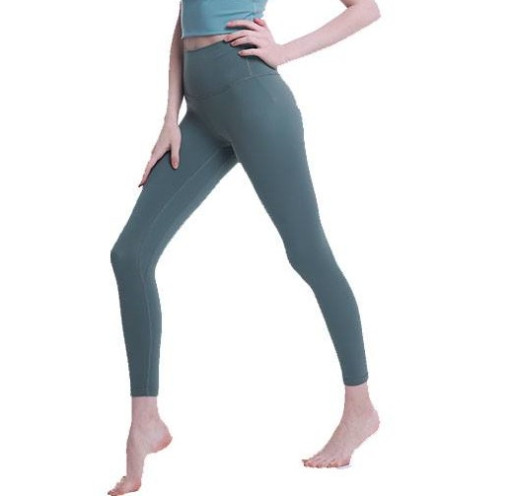

- similarity: 1.00


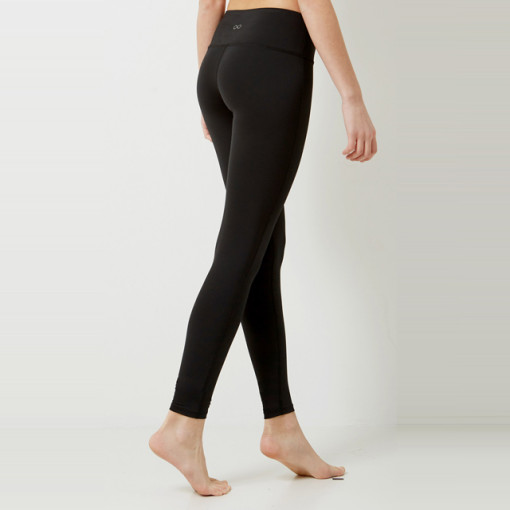

- similarity: 0.79
/content/input_dir/input_img883.jpg


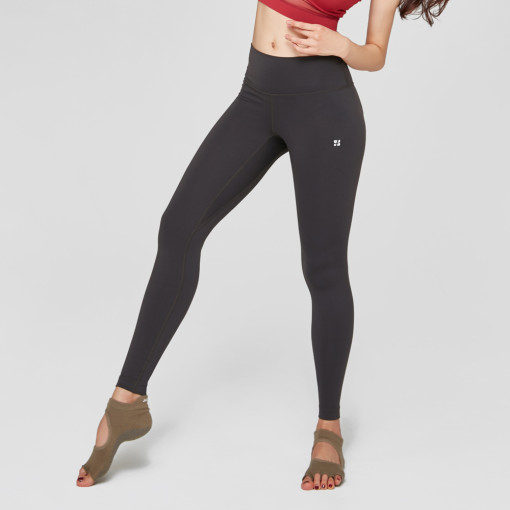

- similarity: 0.78
/content/input_dir/input_img1128.jpg


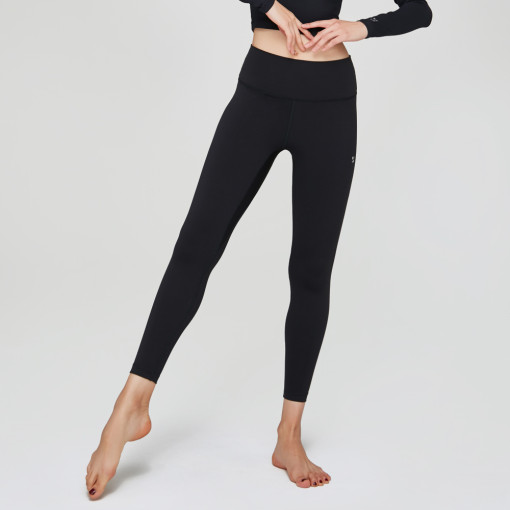

- similarity: 0.78
/content/input_dir/input_img1117.jpg


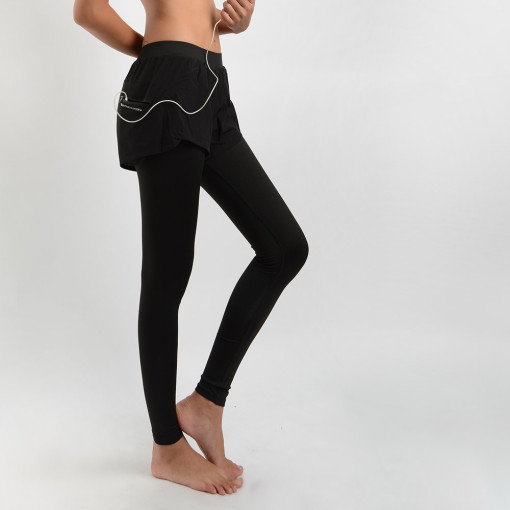

- similarity: 0.77
/content/input_dir/input_img464.jpg


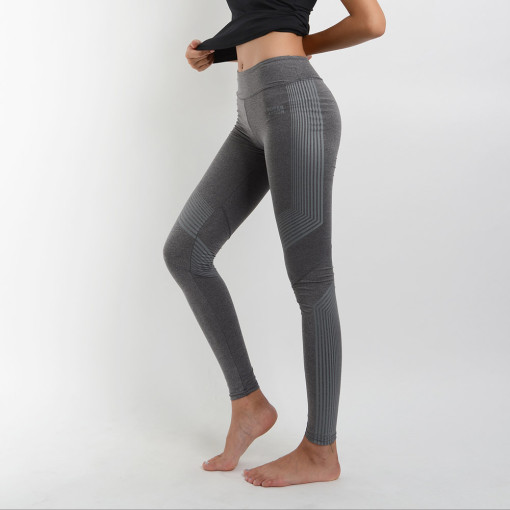

- similarity: 0.77
/content/input_dir/input_img478.jpg


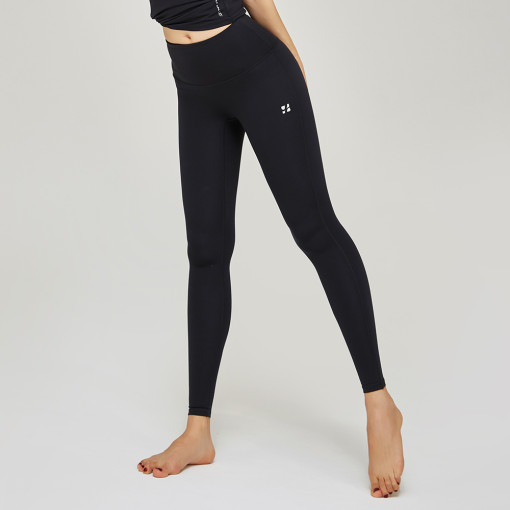

- similarity: 0.77
/content/input_dir/input_img1077.jpg


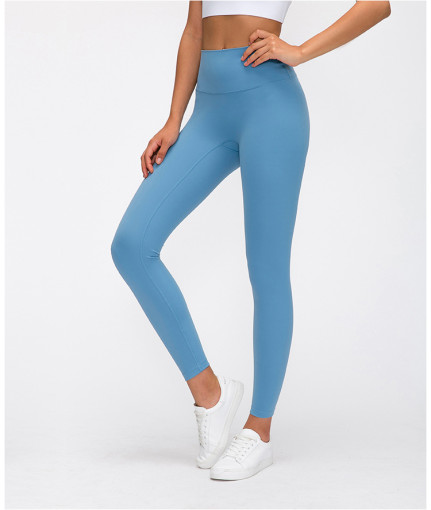

- similarity: 0.77
/content/input_dir/input_img119.jpg


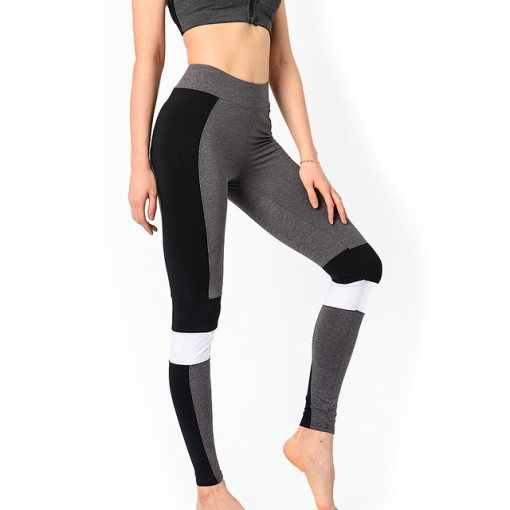

- similarity: 0.77
/content/input_dir/input_img512.jpg


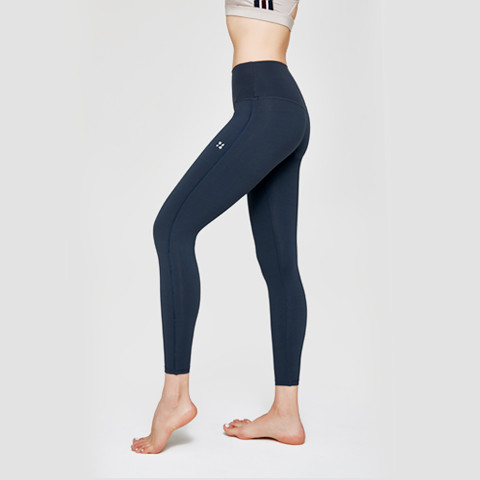

- similarity: 0.77
/content/input_dir/input_img1098.jpg


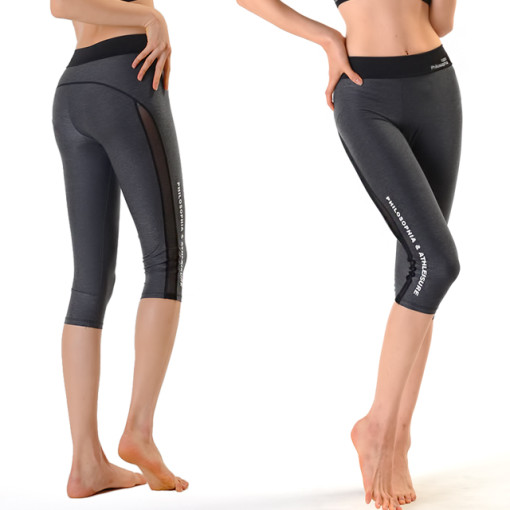

- similarity: 0.77
/content/input_dir/input_img664.jpg


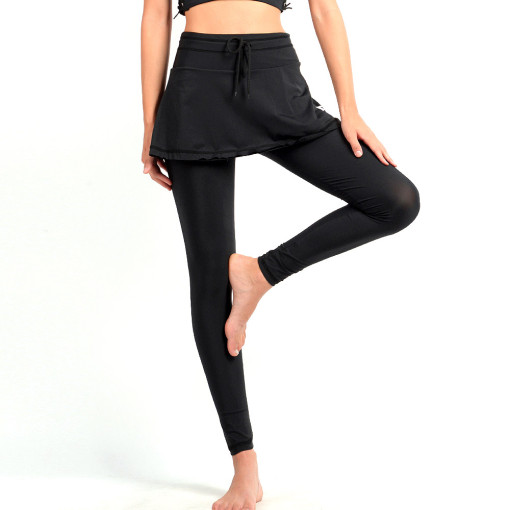

- similarity: 0.77
/content/input_dir/input_img300.jpg


In [17]:
import time
import tensorflow as tf
from IPython.display import Image, display
import os
tf.logging.set_verbosity(tf.logging.ERROR)


# 이미 유사도 측정된 경우(생성되어있는 유사도 csv사용)
file = f'/content/similarity/{target}_similarity.csv'
if os.path.isfile(file):
  print('----exist-----')
  df_result = pd.read_csv(file)
  # Display results
  print("# Target image")
  display(Image(target_img_path))
  print("- similarity: %.2f" % similarities[0])
  cnt = 0
  for index, line in df_result[:20].iterrows():
    if line['similarity'] < 0.9999:
      cnt += 1
      display(Image(line['path']))
      print("- similarity: %.2f" % line['similarity'])
      print(line['path'])
      # print('input:',str(line['path']).split('input_img')[-1].split('.')[0])
      if cnt > 10:
          break

# 새롭게 유사도 csv 생성
else:
# Load bytes of image files
  image_bytes = [tf.gfile.GFile(name, 'rb').read() 
                  for name in [target_img_path] + input_img_paths]

  hub_module_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/1"

  with tf.Graph().as_default():
    input_byte, similarity_op = build_graph(hub_module_url, target_img_path)
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())
      t0 = time.time() # for time check
      
      # Inference similarities
      similarities = sess.run(similarity_op, feed_dict={input_byte: image_bytes})
      print("%d images inference time: %.2f s" % (len(similarities), time.time() - t0))
      
      # result = similarities[1:]
      # for idx, sim in enumerate(result):
      #   overall.iloc[target, idx] = sim
      df_result = pd.DataFrame(sorted(zip(similarities[1:], input_img_paths), reverse=True),columns=['similarity','path'])
      df_result.to_csv(f'/content/similarity/{target}_similarity.csv')

      # Display results
      print("# Target image")
      display(Image(target_img_path))
      print("- similarity: %.2f" % similarities[0])


      print("# Input images")
      cnt = 0
      for similarity, input_img_path in sorted(zip(similarities[1:], input_img_paths), reverse=True):
        
        if similarity < 0.9999:
          cnt += 1
          display(Image(input_img_path))
          print("- similarity: %.2f" % similarity)
          print(input_img_path)

        if cnt > 10: # TOP10까지만 보여주기
          break